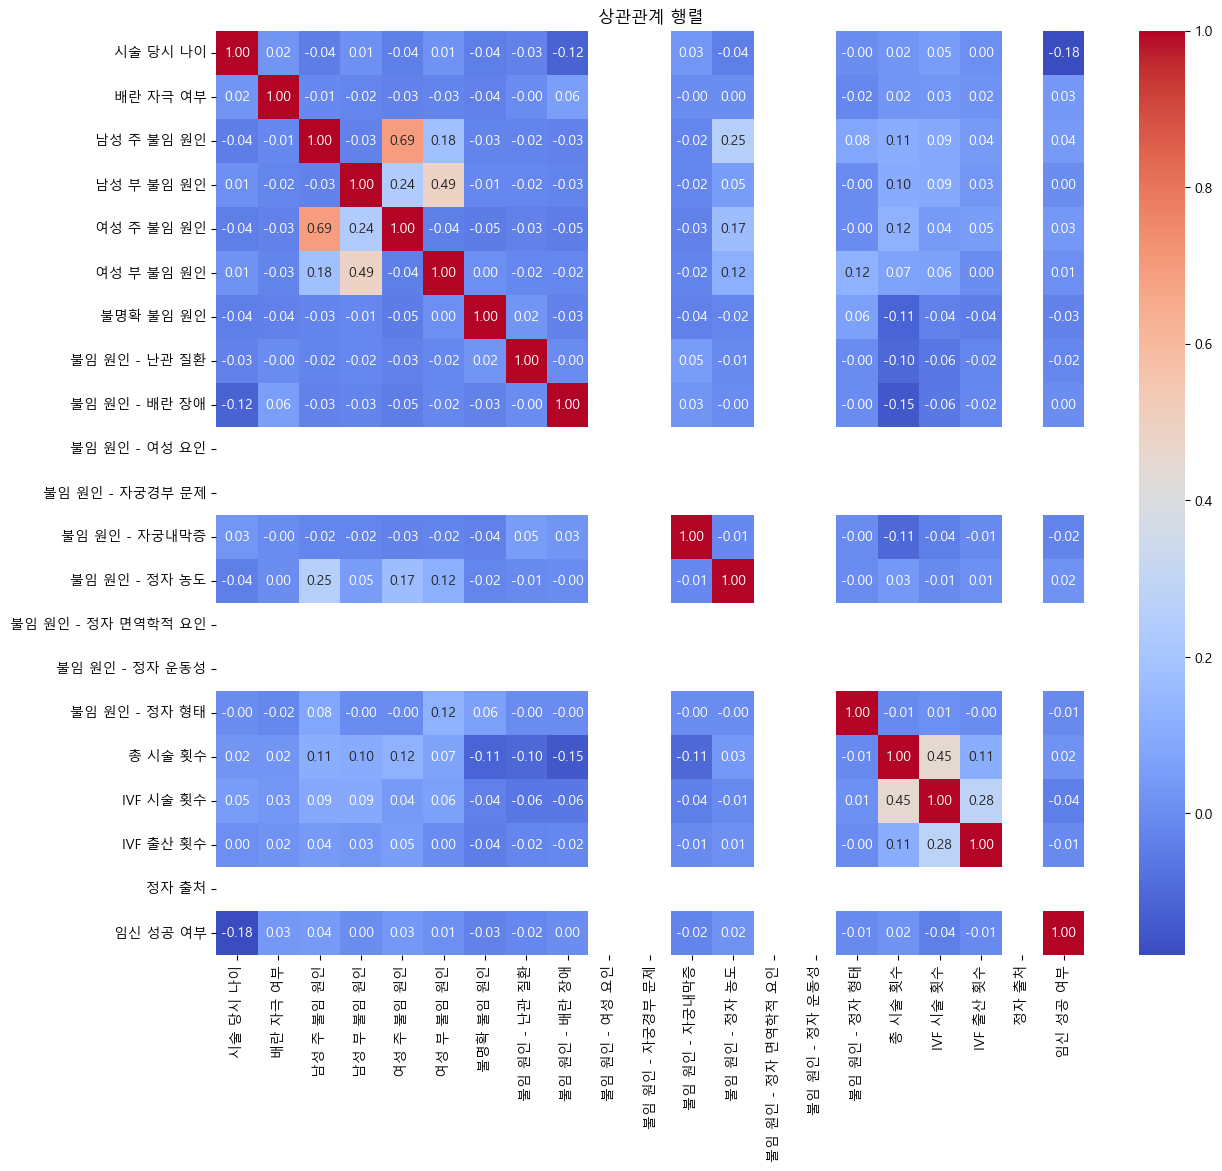

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 불필요한 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Windows의 경우, 다른 OS에서는 적절한 한글 폰트를 사용하세요)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# CSV 파일 읽기 (cp949 인코딩)
df = pd.read_csv("train_di_2-cp949.csv", encoding="cp949")

# 상관관계 도표에 포함하지 않을 칼럼 제거
cols_to_exclude = ['ID', '시술 시기 코드', '시술 유형', 'IVF 임신 횟수', '부부 주 불임 원인', '부부 부 불임 원인']
df_corr = df.drop(columns=cols_to_exclude)

# 수치형 칼럼에 대해 상관관계 행렬 계산
corr_matrix = df_corr.corr()

# 상관관계 행렬 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관관계 행렬")
plt.show()

In [13]:
IVF 임신 횟수, 부부 주 불임 원인, 부부 부 불임 원인

SyntaxError: invalid syntax (3308685718.py, line 1)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, precision_score, roc_auc_score
import lightgbm as lgb

# 1. 데이터 준비 및 전처리
df = pd.read_csv("train_di_2-cp949.csv", encoding="cp949")

# 예측에 사용할 칼럼 제거 (제외할 칼럼 목록)
cols_to_exclude = ['ID', '시술 시기 코드', '시술 유형', 'IVF 임신 횟수', '부부 주 불임 원인', '부부 부 불임 원인']
df_model = df.drop(columns=cols_to_exclude)

# 피처와 타겟 변수 분리 (타겟: '임신 성공 여부')
X = df_model.drop(columns=['임신 성공 여부'])
y = df_model['임신 성공 여부']

# 학습/검증 데이터 분리 (Stratify 옵션 사용)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. 클래스 불균형 보정을 위한 scale_pos_weight 계산
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# 3. 하이퍼파라미터 교차검증 (GridSearchCV)
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 63],
    'max_depth': [-1, 10, 20]
}
# scale_pos_weight를 반영한 모델 생성
lgb_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 4. 검증 데이터 예측 (예측 확률)
y_prob = best_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)

# 5. 다양한 threshold에 따른 평가 결과 출력 (0.3, 0.5, 0.6, 0.7)
for thresh in [0.3, 0.25, 0.4, 0.2]:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    rec = recall_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh)
    roc_auc = roc_auc_score(y_val, y_pred_thresh)
    conf_mat = confusion_matrix(y_val, y_pred_thresh)
    
    print("Threshold: {:.1f}".format(thresh))
    print("Accuracy: {:.4f}".format(acc))
    print("Recall: {:.4f}".format(rec))
    print("Precision: {:.4f}".format(prec))
    print("Roc-auc: {:.4f}".format(roc_auc))
    print("Confusion Matrix:")
    print(conf_mat)
    print("-----------------------------")

scale_pos_weight: 6.751760563380282
Fitting 3 folds for each of 36 candidates, totalling 108 fits
